In [2]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from ploter import PlotDataFrame
from utils import Util


In [3]:
# Define the file path
file_path = '../data/cleaned_data.csv'

# Load the cleaned data into a DataFrame
cleaned_df = pd.read_csv(file_path)
cleaned_df

,Unnamed: 0,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,...,Total UL (Bytes),Total DL (Bytes),Social Media Data Volume (Bytes),Google Data Volume (Bytes),Email Data Volume (Bytes),Youtube Data Volume (Bytes),Netflix Data Volume (Bytes),Gaming Data Volume (Bytes),Other Data Volume (Bytes),Total Data Volume (Bytes)
0,0,-9223372036854775808,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,245107.75,208201448079117,33664962239,35521209507511,...,36749741.0,308879636.0,1570185.0,2905912.0,3701304.0,18355943.0,17855187.0,292426453.0,180558843.0,345629377.0
1,1,-9223372036854775808,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,245107.75,208201909211140,33681854413,35794009006359,...,53800391.0,653384965.0,1933278.0,4414096.0,937385.0,39359124.0,35565545.0,609920783.0,541959383.0,707185356.0
2,2,-9223372036854775808,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,245107.75,208200314458056,33760627129,35281510359387,...,27883638.0,279807335.0,1726277.0,10229119.0,3363124.0,34425237.0,23751202.0,229980251.0,414908351.0,307690973.0
3,3,-9223372036854775808,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,245107.75,208201402342131,33750343200,35356610164913,...,43324218.0,846028530.0,657493.0,11811761.0,2070983.0,36534765.0,15092588.0,810387875.0,761837216.0,889352748.0
4,4,-9223372036854775808,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,245107.75,208201401415120,33699795932,35407009745539,...,38542814.0,569138589.0,912788.0,7748843.0,2110349.0,34222253.0,17539799.0,531237049.0,564619822.0,607681403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146882,149991,7349883264234529792,2019-04-29 07:28:00,794.0,2019-04-30 00:36:00,523.0,61661.00,208201716588303,33762146363,35860607430880,...,57231077.0,295424923.0,915749.0,12036660.0,1730617.0,17269104.0,38337514.0,268231454.0,263493166.0,352656000.0
146883,149992,-9223372036854775808,2019-04-29 07:28:00,114.0,2019-04-30 07:04:00,724.0,84940.00,208201402149148,33761274518,35327007109396,...,45923464.0,70341448.0,1752716.0,7283344.0,954877.0,36814543.0,13742615.0,43581298.0,820617848.0,116264912.0
146884,149993,-9223372036854775808,2019-04-29 07:28:00,79.0,2019-04-30 18:22:00,512.0,125622.00,208201402072093,33626114091,35735309473406,...,43629118.0,623318363.0,2307959.0,12459876.0,2555578.0,26306531.0,40974659.0,571286842.0,179348636.0,666947481.0
146885,149994,-9223372036854775808,2019-04-29 07:28:00,83.0,2019-04-30 15:01:00,268.0,113545.00,208200313074099,33645655643,35155409288696,...,59377936.0,862796008.0,892867.0,8922614.0,1565542.0,42219856.0,28354119.0,825524976.0,792559807.0,922173944.0


In [4]:
# Select the relevant columns from the cleaned_df DataFrame

user_engagement_df = cleaned_df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms)', 'Total Data Volume (Bytes)']]

# Grouping by 'MSISDN/Number' and aggregating the metrics
user_engagement_df = user_engagement_df.groupby('MSISDN/Number').agg({'Bearer Id': 'count', 'Dur. (ms)': 'sum', 'Total Data Volume (Bytes)': 'sum'})
#Renaming columns:
user_engagement_df = user_engagement_df.rename(
    columns={'Bearer Id': 'xDR Sessions'})
user_engagement_df.head(5)


,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33601001722,1,116720.0,8.786906e+08
33601001754,1,181230.0,1.568596e+08
33601002511,1,134969.0,5.959665e+08
33601007832,1,49878.0,4.223207e+08
33601008617,2,37104.0,1.457411e+09


In [5]:
# Top 10 Customers per xDR sessions

user_engagement_df.nlargest(10, 'xDR Sessions')

,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33626320676,18,4007341.50,7.971167e+09
33614892860,17,3900319.50,8.846226e+09
33625779332,17,4138392.00,8.499621e+09
33659725664,16,3492565.50,7.705863e+09
33675877202,15,3332218.50,7.891111e+09
33760536639,15,3396880.25,8.514774e+09
33667163239,13,3114208.00,5.618394e+09
33603127838,12,2855532.25,4.976195e+09
33604515716,12,2780120.50,5.487855e+09


In [6]:
# Top ten customer per duration
user_engagement_df.nlargest(10, 'Dur. (ms)')


,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33625779332,17,4138392.00,8.499621e+09
33626320676,18,4007341.50,7.971167e+09
33614892860,17,3900319.50,8.846226e+09
33659725664,16,3492565.50,7.705863e+09
33760536639,15,3396880.25,8.514774e+09
33675877202,15,3332218.50,7.891111e+09
33667163239,13,3114208.00,5.618394e+09
33603127838,12,2855532.25,4.976195e+09
33627080969,12,2782427.50,5.754731e+09


In [7]:
# Top ten customer per traficc
user_engagement_df.nlargest(10, 'Total Data Volume (Bytes)')


,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,
33614892860,17,3900319.50,8.846226e+09
33760536639,15,3396880.25,8.514774e+09
33625779332,17,4138392.00,8.499621e+09
33626320676,18,4007341.50,7.971167e+09
33675877202,15,3332218.50,7.891111e+09
33659725664,16,3492565.50,7.705863e+09
33666464084,11,2597081.75,7.308501e+09
33760413819,12,2676855.75,7.132371e+09
33664712899,11,2603565.25,6.872337e+09


<Axes: >

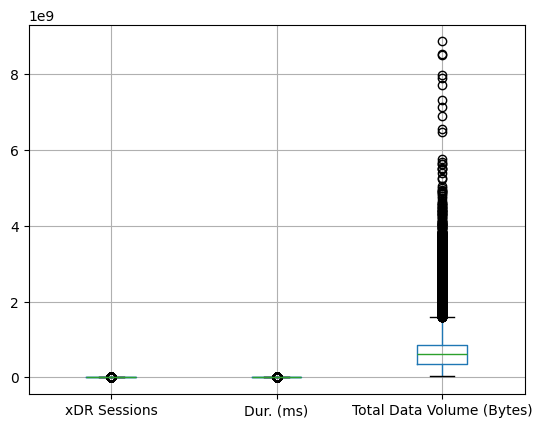

In [8]:
# Outlier Handling
#Creating instance of our util class
df_util = Util(user_engagement_df)
user_engagement_df.boxplot()

In [9]:
df_util.getOverview(['xDR Sessions', 'Dur. (ms)', 'Total Data Volume (Bytes)'])

Name of columns,Dur. (ms),Total Data Volume (Bytes),xDR Sessions
Min,7142.0,33249009.0,1.0
Q1,72726.5,357937385.25,1.0
Median,103112.5,616932960.5,1.0
Q3,172799.0,856483490.5,2.0
Max,4138392.0,8846226494.0,18.0
IQR,100072.5,498546105.25,1.0
Lower fence,-77382.25,-389881772.625,-0.5
Upper fence,322907.75,1604302648.375,3.5
Skew,5.489774,2.232846,3.317168
Number_of_outliers,6880,5148,3144


In [10]:
#replace outliers in specified columns of a DataFrame with the upper and lower fences
df_util.replace_outliers_with_fences(['xDR Sessions', 'Dur. (ms)', 'Total Data Volume (Bytes)'])
df_util.getOverview(['xDR Sessions', 'Dur. (ms)', 'Total Data Volume (Bytes)'])

Name of columns,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
Min,1.0,7142.0,33249009.0
Q1,1.0,72726.5,357937385.25
Median,1.0,103112.5,616932960.5
Q3,2.0,172799.0,856483490.5
Max,3.5,322907.75,1604302648.375
IQR,1.0,100072.5,498546105.25
Lower fence,-0.5,-77382.25,-389881772.625
Upper fence,3.5,322907.75,1604302648.375
Skew,1.799445,0.808232,0.762778
Number_of_outliers,0,0,0


In [11]:
user_engagement_df.boxplot()


<Axes: >

In [12]:
# Create an instance of the StandardScaler
scaler_instance = StandardScaler()
# Fit and transform the data using the scaler
scaled_data = scaler_instance.fit_transform(user_engagement_df)
scaled_data

array([[-0.54866182, -0.14577626,  0.54827419],
       [-0.54866182,  0.61462134, -1.28049119],
       [-0.54866182,  0.06932986, -0.16800992],
       ...,
       [-0.54866182, -1.41774192,  0.13265469],
       [-0.54866182,  0.14027751, -0.46103345],
       [-0.54866182,  1.36756642, -0.1671958 ]])

In [13]:
# Normalize the already scaled data using the normalize function
# The resulting normalized_data is a NumPy array where each row has been normalized.

normalized_data = normalize(scaled_data)
normalized_data

array([[-0.6951856 , -0.18470678,  0.69469446],
       [-0.36033476,  0.40365381, -0.84096519],
       [-0.94927066,  0.11995149, -0.29068342],
       ...,
       [-0.35954686, -0.92906894,  0.08693074],
       [-0.7513382 ,  0.19209621, -0.63133981],
       [-0.36997313,  0.92217614, -0.11274332]])

In [14]:
# Apply k-means clustering with 3 clusters to the normalized data
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_


array([1, 2, 2, ..., 1, 2, 2], dtype=int32)

In [15]:
user_engagement_df.insert(0, 'cluster', kmeans.labels_)
user_engagement_df

,cluster,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
MSISDN/Number,,,,
33601001722,1,1.0,116720.00,8.786906e+08
33601001754,2,1.0,181230.00,1.568596e+08
33601002511,2,1.0,134969.00,5.959665e+08
33601007832,1,1.0,49878.00,4.223207e+08
33601008617,0,2.0,37104.00,1.457411e+09
...,...,...,...,...
33789967113,2,1.0,160461.00,2.081231e+08
33789980299,0,2.0,210389.00,1.094693e+09
33789996170,1,1.0,8810.00,7.146416e+08


In [16]:
user_engagement_df['cluster'].value_counts()


cluster
1    52874
0    28335
2    24507
Name: count, dtype: int64

In [17]:
sns.pairplot(
    user_engagement_df[['cluster','xDR Sessions', 'Dur. (ms)', 'Total Data Volume (Bytes)']],
     hue = 'cluster', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height=4
);

In [18]:
cluster0 = user_engagement_df[user_engagement_df["cluster"]==0]
cluster0[['xDR Sessions', 'Dur. (ms)', 'Total Data Volume (Bytes)']].describe()
#Statistical information for cluster0

,xDR Sessions,Dur. (ms),Total Data Volume (Bytes)
count,28335.000000,28335.000000,2.833500e+04
mean,2.318546,207835.818784,1.114861e+09
std,0.548000,93303.227428,3.728282e+08
min,2.000000,18235.000000,1.197685e+08
25%,2.000000,131463.500000,8.341122e+08
50%,2.000000,200173.000000,1.115265e+09
75%,3.000000,318005.000000,1.466215e+09
max,3.500000,322907.750000,1.604303e+09


In [19]:
df_tele_user_app_engagement = cleaned_df[['MSISDN/Number', 'Social Media Data Volume (Bytes)', 'Google Data Volume (Bytes)',
    'Email Data Volume (Bytes)', 'Youtube Data Volume (Bytes)', 'Netflix Data Volume (Bytes)',
    'Gaming Data Volume (Bytes)', 'Other Data Volume (Bytes)']]

In [20]:
# aggregating user engagement metrics per user

df_user_app_engagement = df_tele_user_app_engagement.groupby(
    'MSISDN/Number').sum()
df_user_app_engagement.head()

,Social Media Data Volume (Bytes),Google Data Volume (Bytes),Email Data Volume (Bytes),Youtube Data Volume (Bytes),Netflix Data Volume (Bytes),Gaming Data Volume (Bytes),Other Data Volume (Bytes)
MSISDN/Number,,,,,,,
33601001722,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
33601001754,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
33601002511,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
33601007832,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
33601008617,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


In [21]:
youtube = df_user_app_engagement.nlargest(10, "Youtube Data Volume (Bytes)")['Youtube Data Volume (Bytes)']
netflix = df_user_app_engagement.nlargest(10, "Netflix Data Volume (Bytes)")['Netflix Data Volume (Bytes)']
gaming = df_user_app_engagement.nlargest(10, "Gaming Data Volume (Bytes)")['Gaming Data Volume (Bytes)']
email = df_user_app_engagement.nlargest(10, "Email Data Volume (Bytes)")['Email Data Volume (Bytes)']
google = df_user_app_engagement.nlargest(10, "Google Data Volume (Bytes)")['Google Data Volume (Bytes)']
social_media = df_user_app_engagement.nlargest(10, "Social Media Data Volume (Bytes)")['Social Media Data Volume (Bytes)']
other = df_user_app_engagement.nlargest(10, "Other Data Volume (Bytes)")['Other Data Volume (Bytes)']

In [22]:
kmeans = KMeans(n_clusters=6, random_state=6).fit(normalized_data)
kmeans.labels_
#Using the elbow method it is suggested that k=6 is an optimal number of cluster

array([1, 3, 3, ..., 1, 3, 3], dtype=int32)

## 

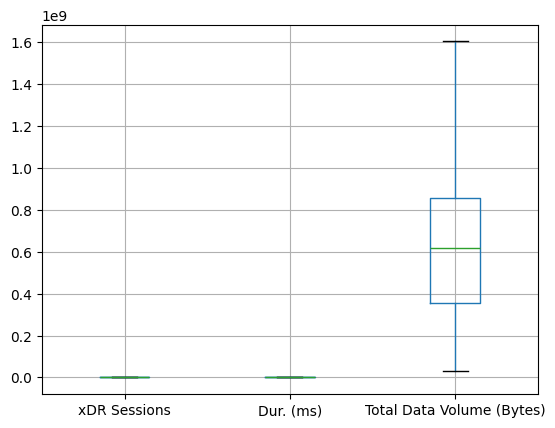

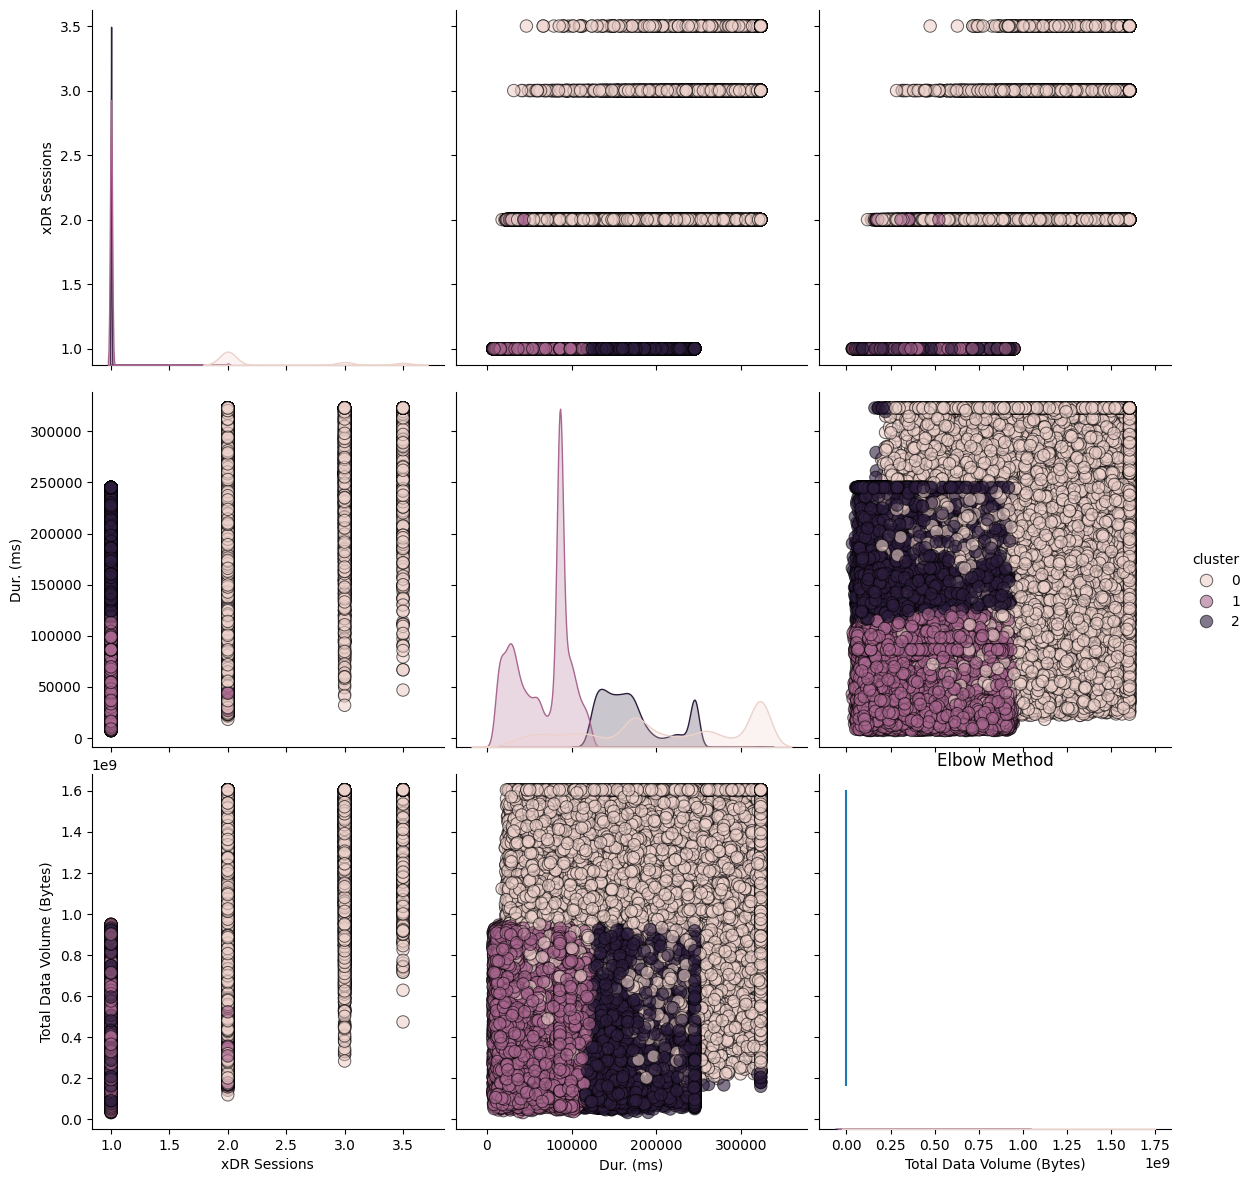

In [23]:
# Calculate the within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_user_app_engagement)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


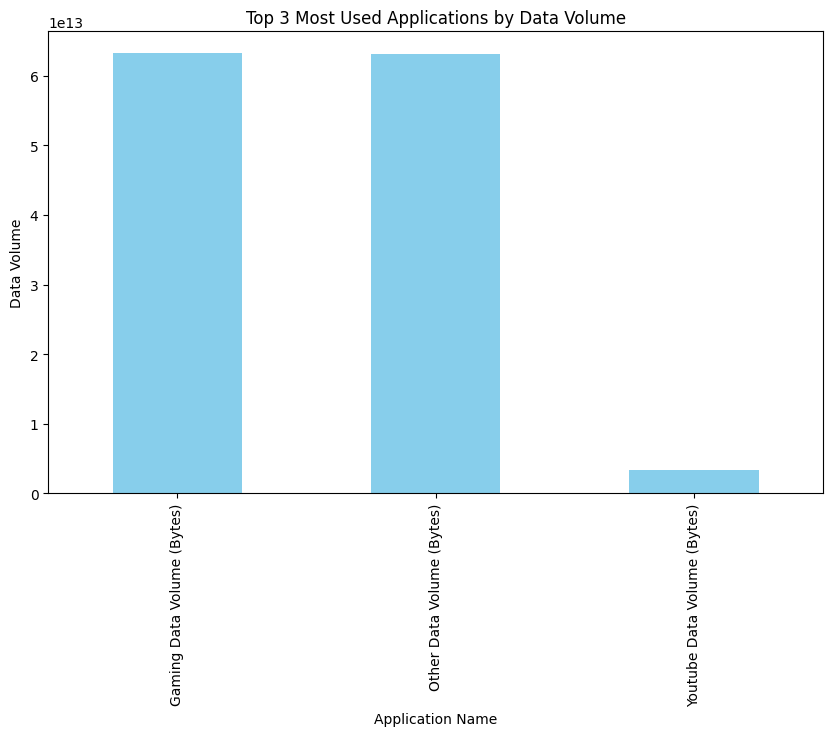

In [24]:
# Calculate the total data volume for each application
total_data_volume = df_user_app_engagement.sum()

# Select the top 3 most used applications
top_3_apps = total_data_volume.nlargest(3)

# Create a bar plot to visualize the top 3 most used applications
plt.figure(figsize=(10, 6))
top_3_apps.plot(kind='bar', color='skyblue')
plt.title('Top 3 Most Used Applications by Data Volume')
plt.xlabel('Application Name')
plt.ylabel('Data Volume')
plt.show()


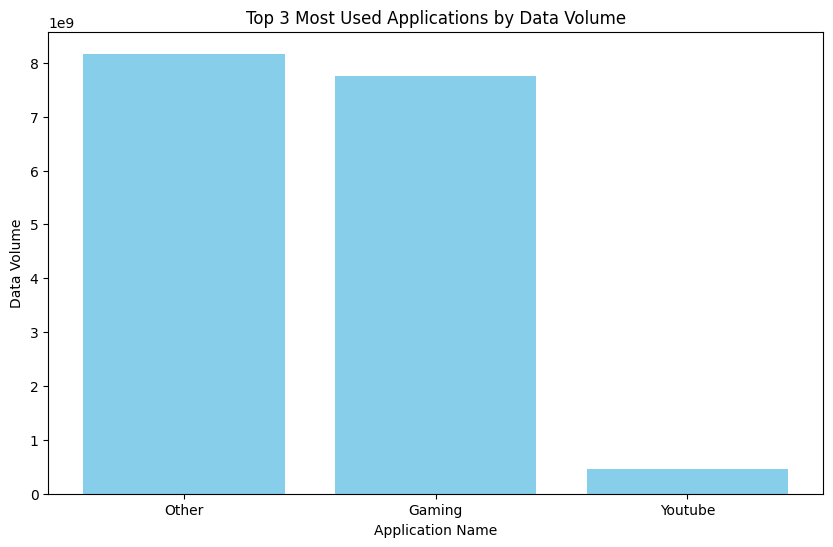

In [25]:

# Top 3 Most Used Applications by Data Volume
app_names = ['Youtube', 'Netflix', 'Gaming', 'Email', 'Google', 'Social Media', 'Other']
data_volumes = [youtube.iloc[0], netflix.iloc[0], gaming.iloc[0], email.iloc[0], google.iloc[0], social_media.iloc[0], other.iloc[0]]

# Select the top 3 most used applications
top_3_apps = sorted(zip(app_names, data_volumes), key=lambda x: x[1], reverse=True)[:3]
top_3_app_names = [x[0] for x in top_3_apps]
top_3_data_volumes = [x[1] for x in top_3_apps]

# Create a bar plot to visualize the top 3 most used applications
plt.figure(figsize=(10, 6))
plt.bar(top_3_app_names, top_3_data_volumes, color='skyblue')
plt.title('Top 3 Most Used Applications by Data Volume')
plt.xlabel('Application Name')
plt.ylabel('Data Volume')
plt.show()


In [26]:

# Specify the file path and name for the CSV file
user_engagement_df.to_csv('../data/user_engagment.csv')

#Saveing the clustering model
with open("../models/user_engagment.pkl", "wb") as f:
    pickle.dump(kmeans, f)